# Reprogramming dataset (dynamic barcoding)

The reprogramming dataset from *Biddy, B. A. et al. Nature 564, 219–224 (2018)*. This dataset has multiple time points for both the clones and the state measurements. 

The cells are barcoded over 3 rounds during the entire differentiation process. We treat
barcode tags from each round as independent clonal label here. In this representation, 
each cell can have multiple clonal labels at different time points.

**Key components**:

* Part I: Infer transition map using clones from all time points

* Part II: Infer transition map using clones from the last time point

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity=3
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

Running cospar 0.0.8 (python 3.6.12) on 2021-02-17 17:56.


## Loading data

In [3]:
adata_orig=cs.datasets.reprogramming_dynamic_BC()

In [4]:
adata_orig

AnnData object with n_obs × n_vars = 18803 × 28001
    obs: 'time_info', 'state_info'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'state_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca'

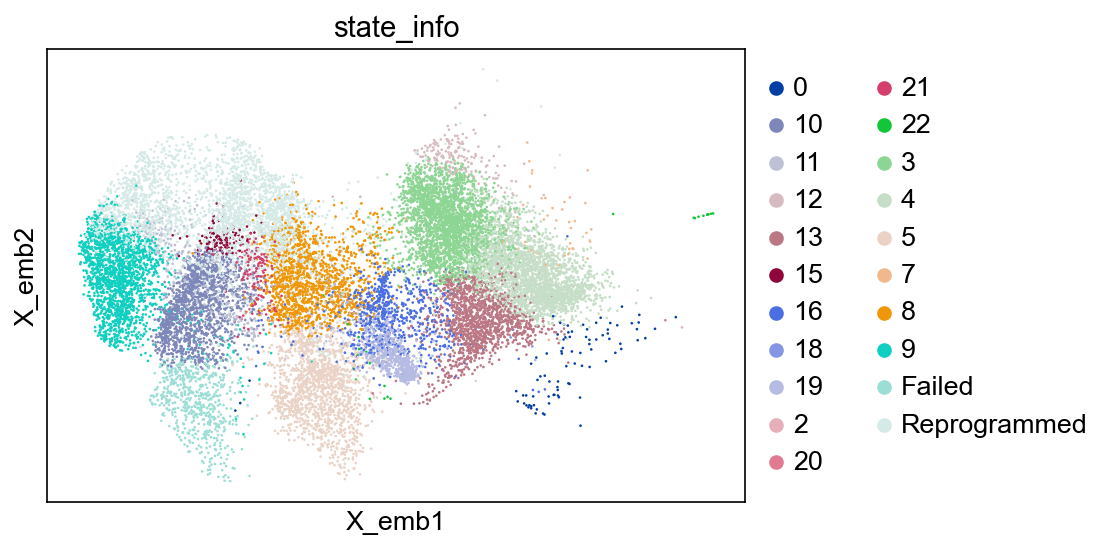

In [5]:
cs.pl.embedding(adata_orig,color='state_info')

In [6]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['18', '19', '5', '21', '20', '13', '11', 'Reprogrammed', '22', '2', '8', '16', '3', '7', '9', '15', '0', '10', 'Failed', '12', '4']
Available time points: ['8', '5', '7', '3', '6', '4']
Clonal time points: ['8', '5', '7', '3', '6', '4']


## Raw clonal data analysis

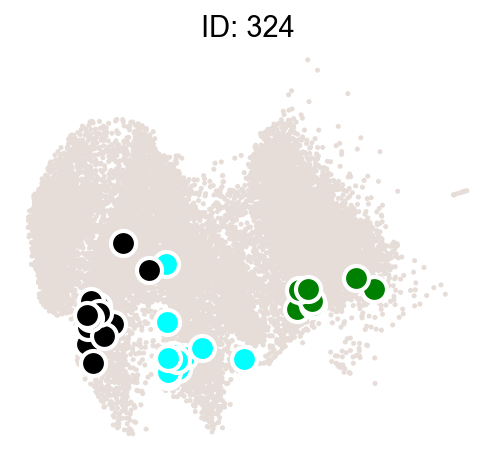

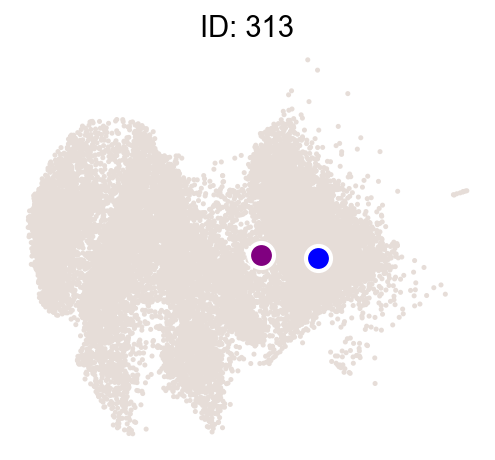

In [7]:
#cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1],color_list=['black','red','blue'])

cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[324,313]) #324,313,446,716,367

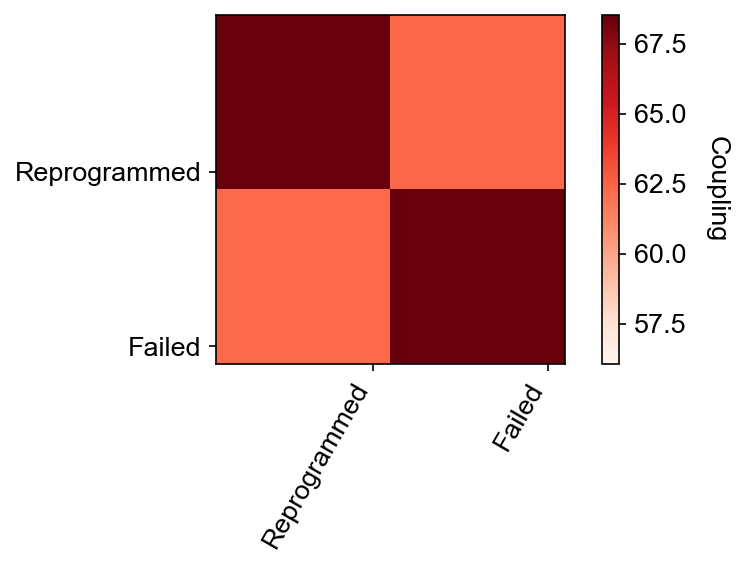

In [8]:
selected_time_point='8'
selected_fates=['Reprogrammed','Failed']
cs.pl.fate_coupling_from_clones(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

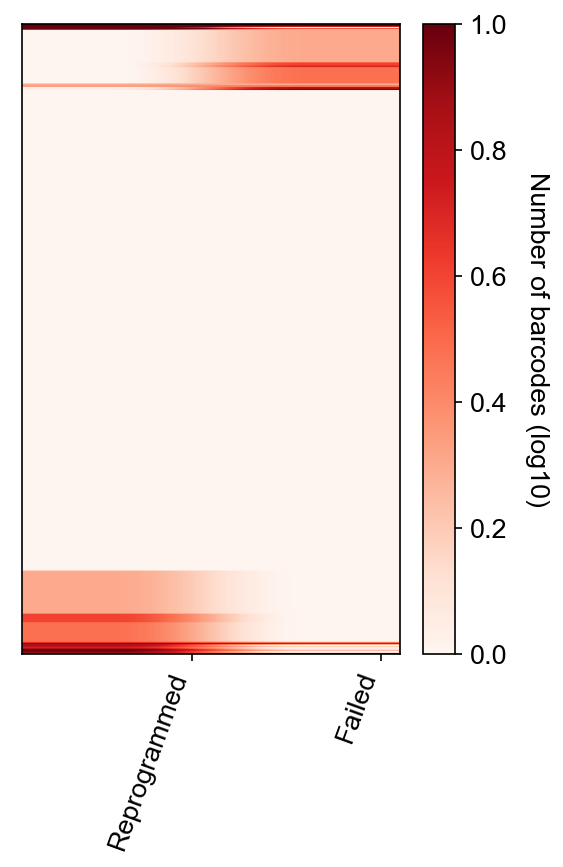

In [9]:
selected_time_point='8'
cs.pl.barcode_heatmap(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

The computation requires simulation, with time linearly proportional to N_resampling, and the number of clones. Can take hours for big data. 

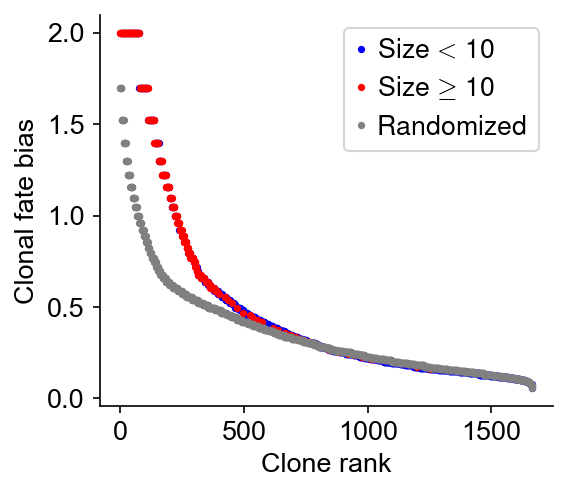

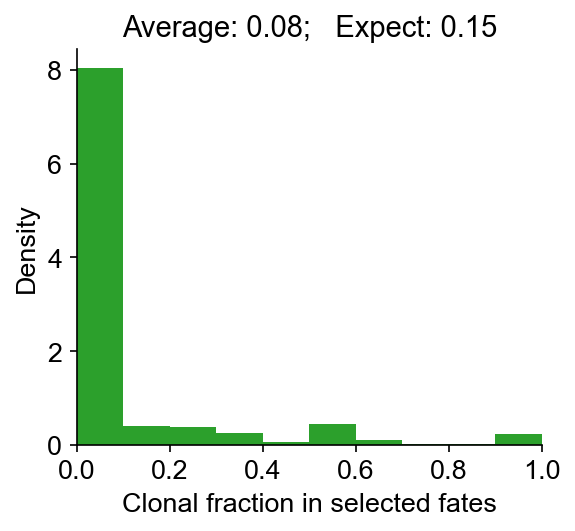

In [10]:
clonal_fate_bias,clone_id=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Reprogrammed',
    clone_size_thresh=10,N_resampling=100,compute_new=False)

## Part I: Infer transition map using clones from all time points

### Map inference

Running it the first time takes 20 mins, 17 mins of which are used to compute the similarity matrix. When it is run again, it only takes 3 mins.

-------Step 1: Select time points---------
Current time ordering from simple sorting: ['3' '4' '5' '6' '7' '8']
--> Clonal cell fraction (day 3-4): 0.5632183908045977
--> Clonal cell fraction (day 4-5): 0.8427464008859358
--> Clonal cell fraction (day 5-6): 0.8514851485148515
--> Clonal cell fraction (day 6-7): 0.8354622871046229
--> Clonal cell fraction (day 7-8): 0.854301948051948
--> Clonal cell fraction (day 4-3): 0.12181616832779624
--> Clonal cell fraction (day 5-4): 0.7069306930693069
--> Clonal cell fraction (day 6-5): 0.9105839416058394
--> Clonal cell fraction (day 7-6): 0.890625
--> Clonal cell fraction (day 8-7): 0.9279731993299832
--> Numer of cells that are clonally related -- day 3: 49  and day 4: 110
--> Numer of cells that are clonally related -- day 4: 761  and day 5: 2142
--> Numer of cells that are clonally related -- day 5: 2580  and day 6: 2994
--> Numer of cells that are clonally related -- day 6: 2747  and day 7: 4389
--> Numer of cells that are clonally related

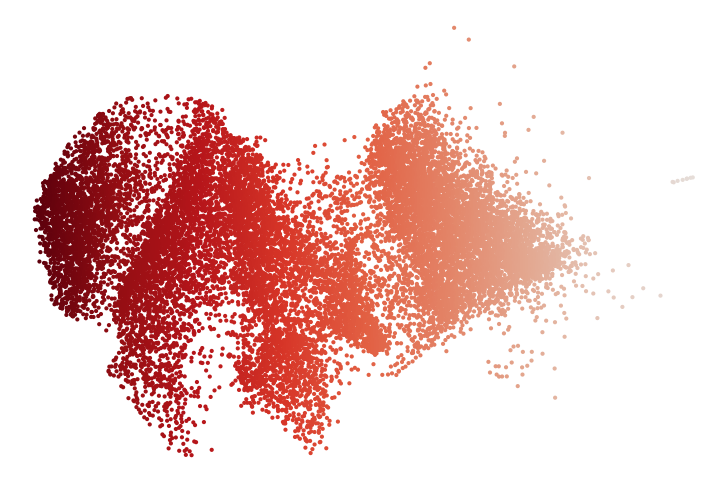

In [11]:
noise_threshold=0.2 # 
selected_clonal_time_points=['3','4','5','6','7','8']
#selected_clonal_time_points=['7','8']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,selected_clonal_time_points,smooth_array=[15,10,5],
        noise_threshold=noise_threshold,demulti_threshold=noise_threshold,use_full_Smatrix=True)

### Save or load pre-computed data (optional)

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [12]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    ## Updated Jan 28, 2021
    #data_des='CellTagging_NoConcat_TwoTimeClone_t*3*4*5*6*7*8'
    data_des='CellTagging_NoConcat_OneTimeClone_t*3*4*5*6*7*8'
    adata=cs.hf.load_saved_adata_with_key(data_des)


In [13]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Available clusters: ['18', '19', '5', '21', '20', '13', '11', 'Reprogrammed', '22', '2', '8', '16', '3', '7', '9', '15', '0', '10', 'Failed', '12', '4']
Available time points: ['8', '5', '7', '3', '6', '4']
Clonal time points: ['8', '5', '7', '3', '6', '4']


### Plotting

There are some common parameters:

* `used_map_name` (str). It determines which transition map to use for analysis. Choices: {‘transition_map’, ‘intraclone_transition_map’, ‘OT_transition_map’, ‘HighVar_transition_map’,’clonal_transition_map’}

* `selected_fates` (list of str). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. It allows nested structure, e.g., selected_fates=[‘a’, [‘b’, ‘c’]] selects two clusters: cluster ‘a’ and the other that combines ‘b’ and ‘c’.

* `map_backwards` (bool). We can analyze either the forward transitions, i.e., where the selected states or clusters are going (map_backwards=False), or the backward transitions, i.e., where these selected states or clusters came from (map_backwards=True). The latter is more useful, and is the default.

* `selected_time_points` (list). List of time points to use. By default, all are used. 

#### Transition profiles for single cells

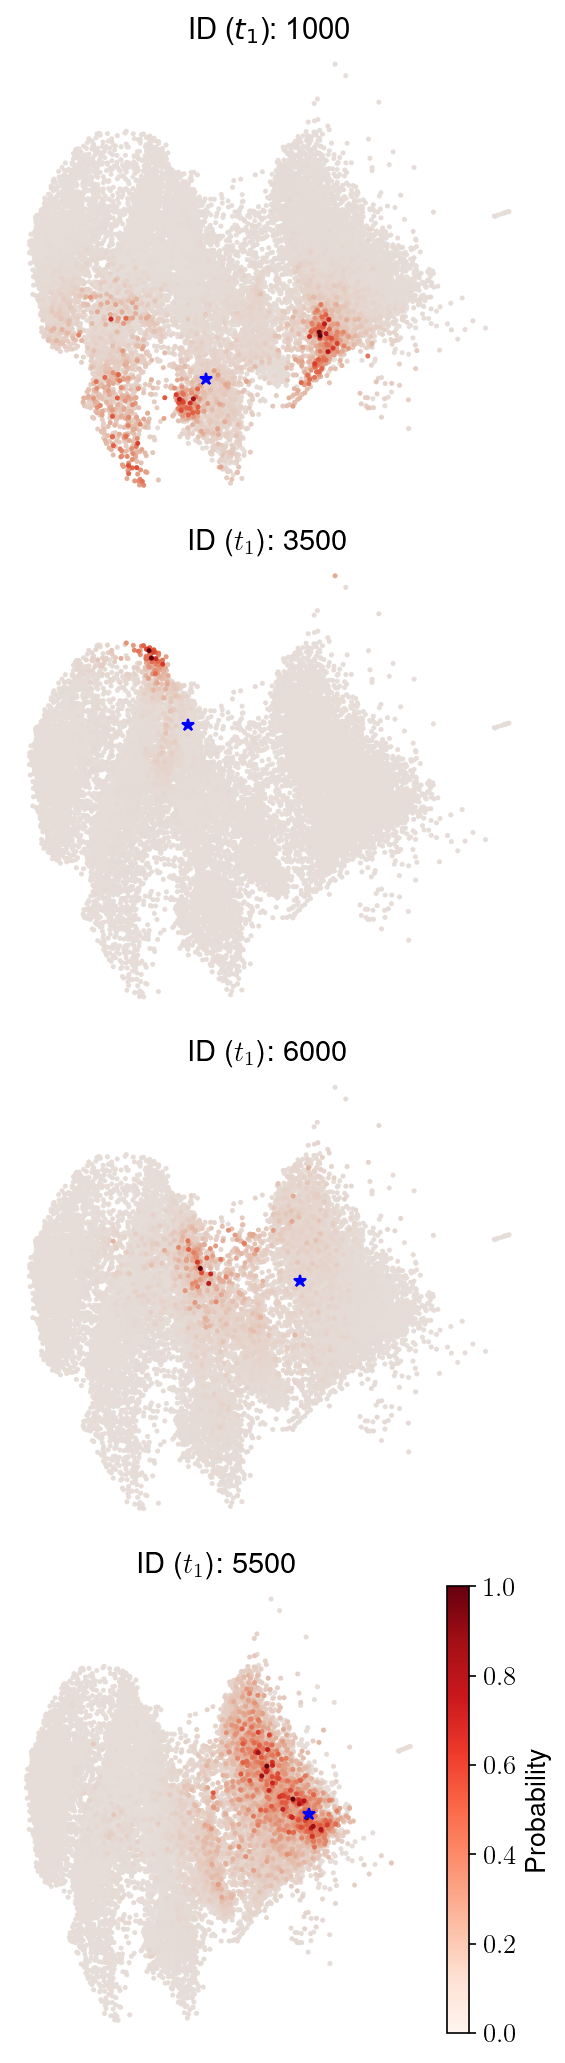

In [14]:
selected_state_id_list=[1000,3500,6000,5500]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=False)

#### Fate map

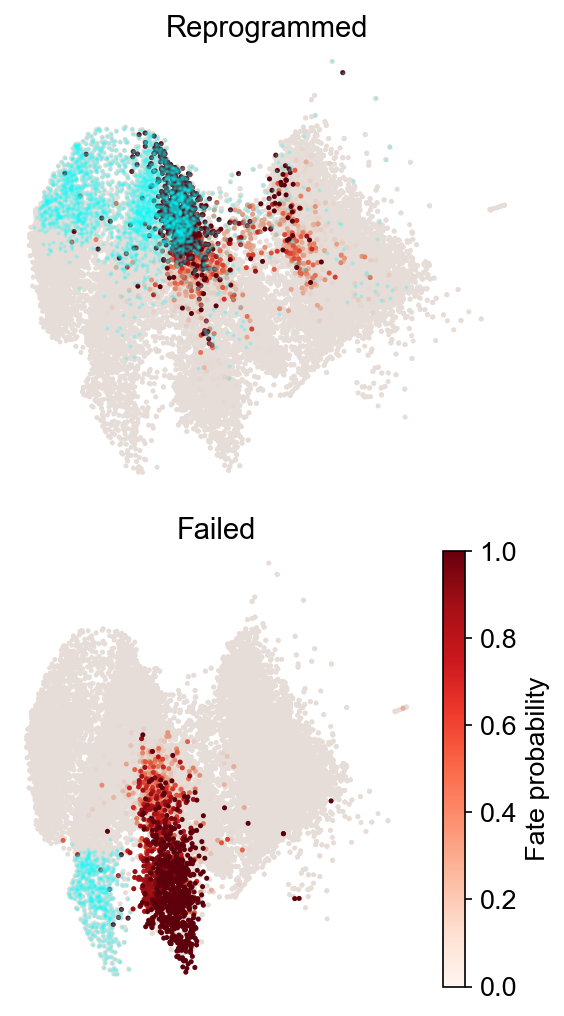

In [15]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='intraclone_transition_map',map_backwards=True,plot_target_state=True)

#### Relative fate bias

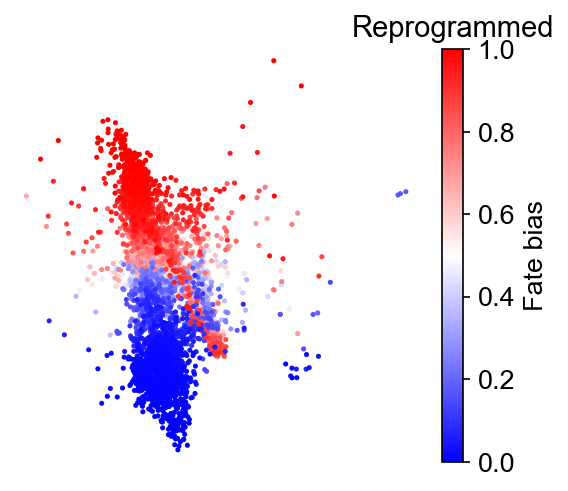

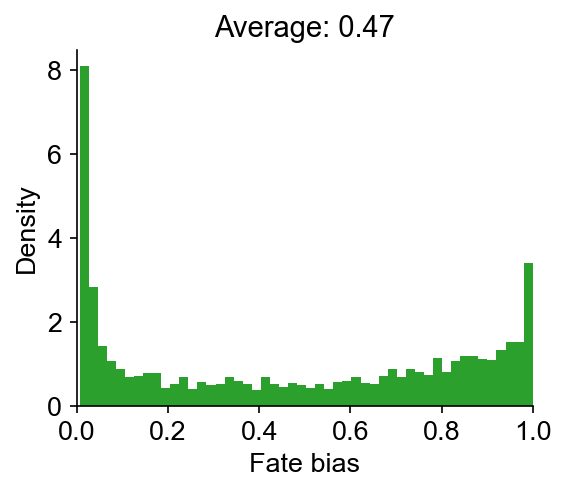

In [16]:
cs.pl.binary_fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=['7'],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0)

#### Identify differentially expressed genes

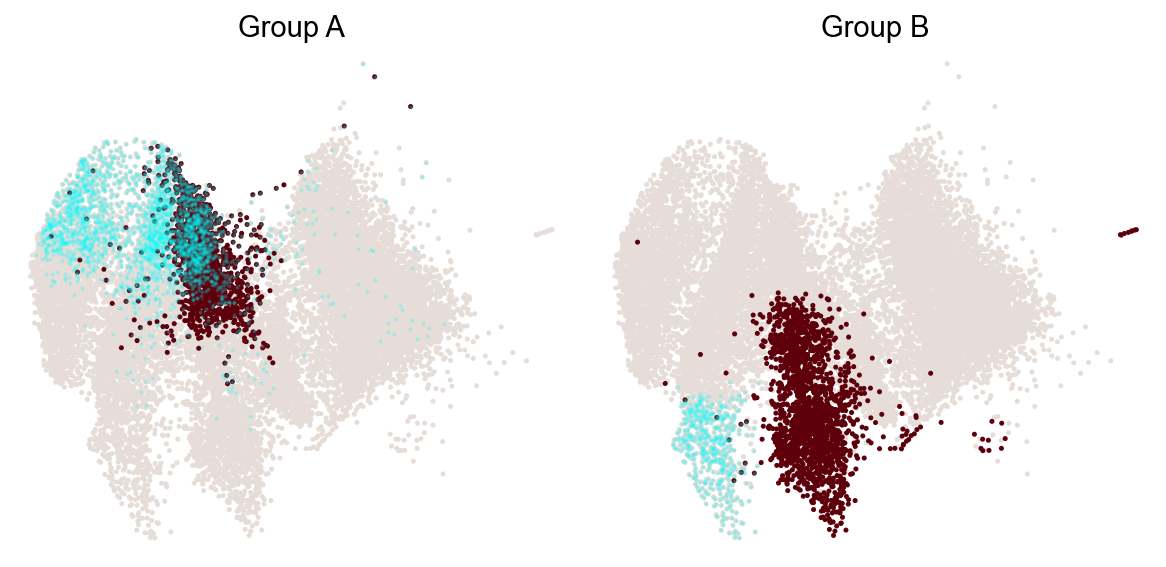

In [17]:
cs.pl.dynamic_trajectory_from_binary_fate_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


#### Map trajectory backwards iteratively

From our experience, it is better to use the intra-clone transition map to compute the trajectory 

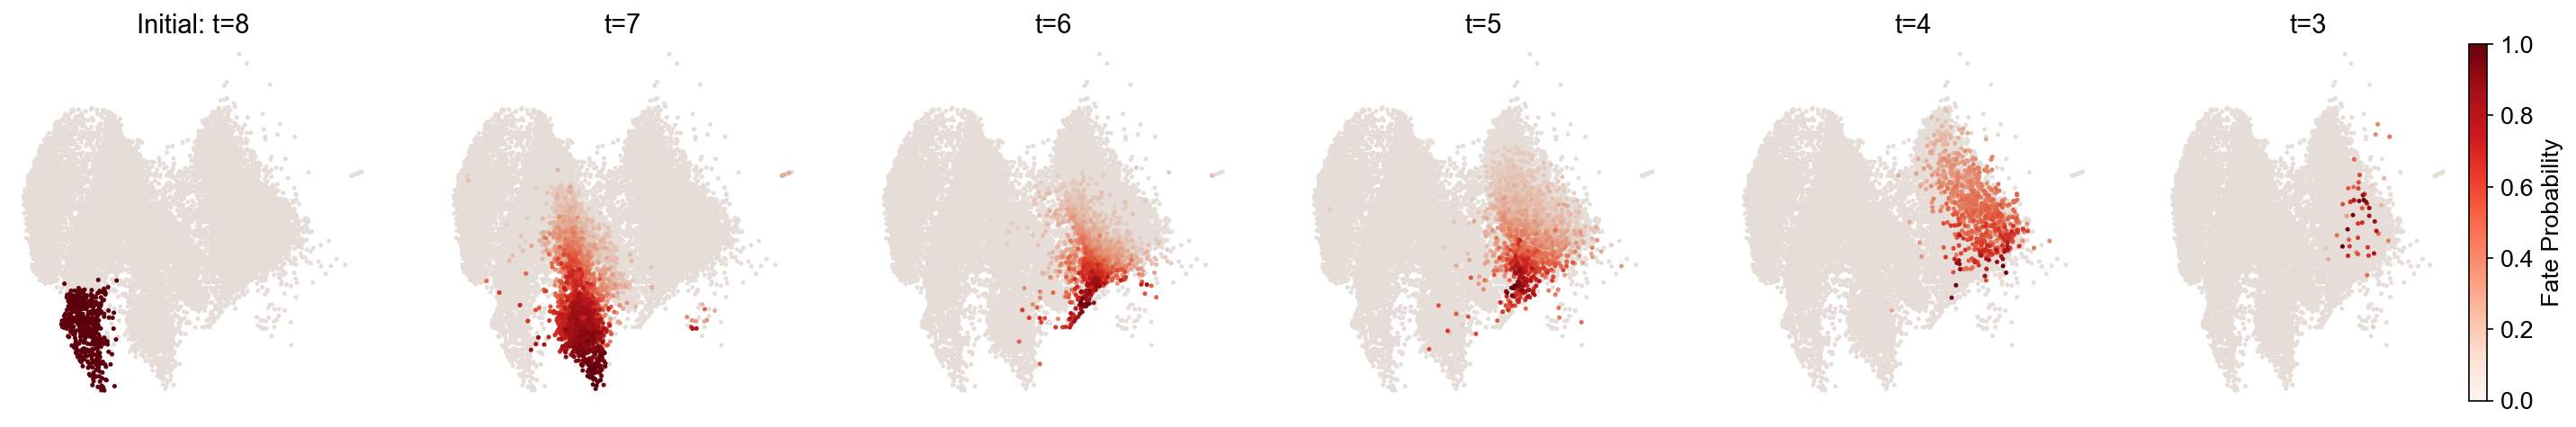

In [18]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.1, plot_separately=True, apply_time_constaint=True)

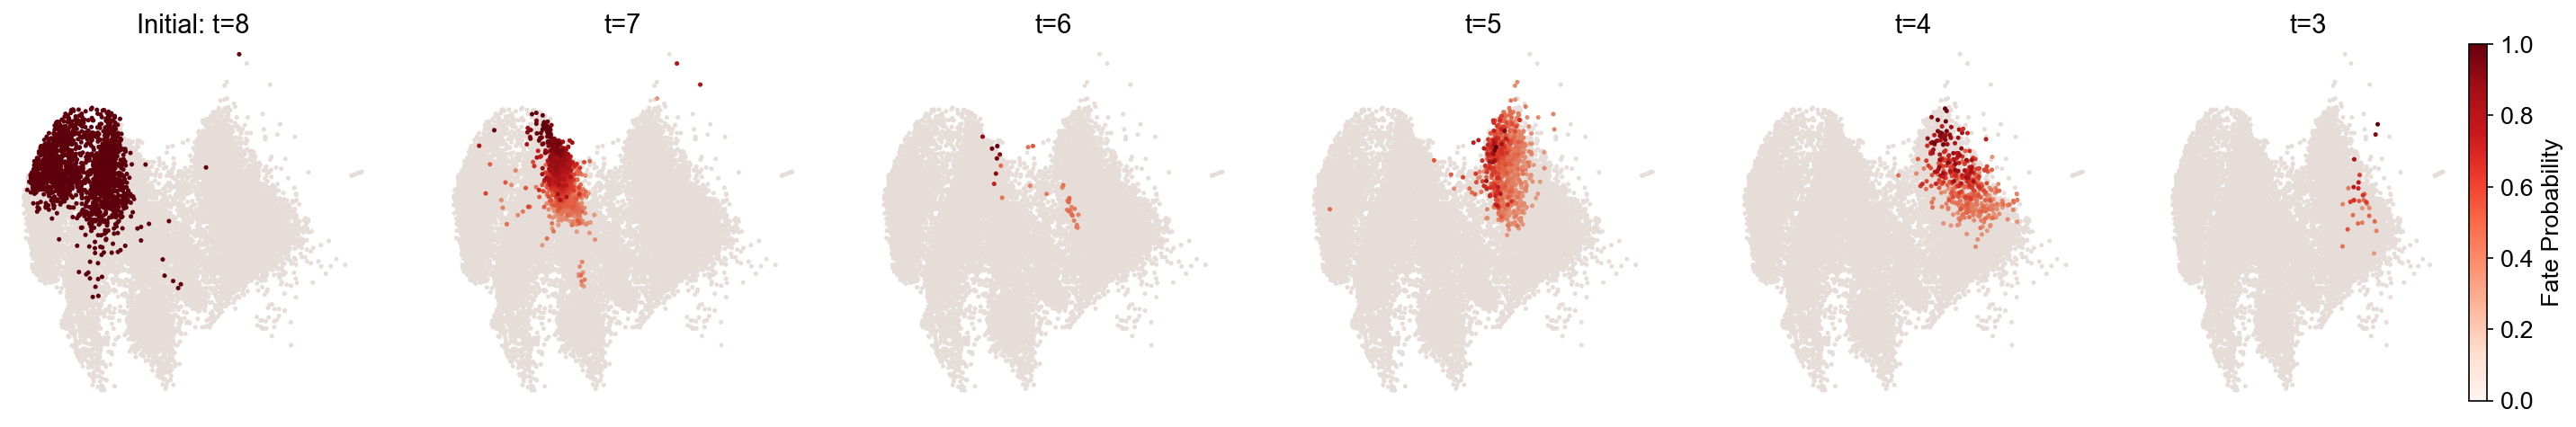

In [19]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.3, plot_separately=True, apply_time_constaint=True)

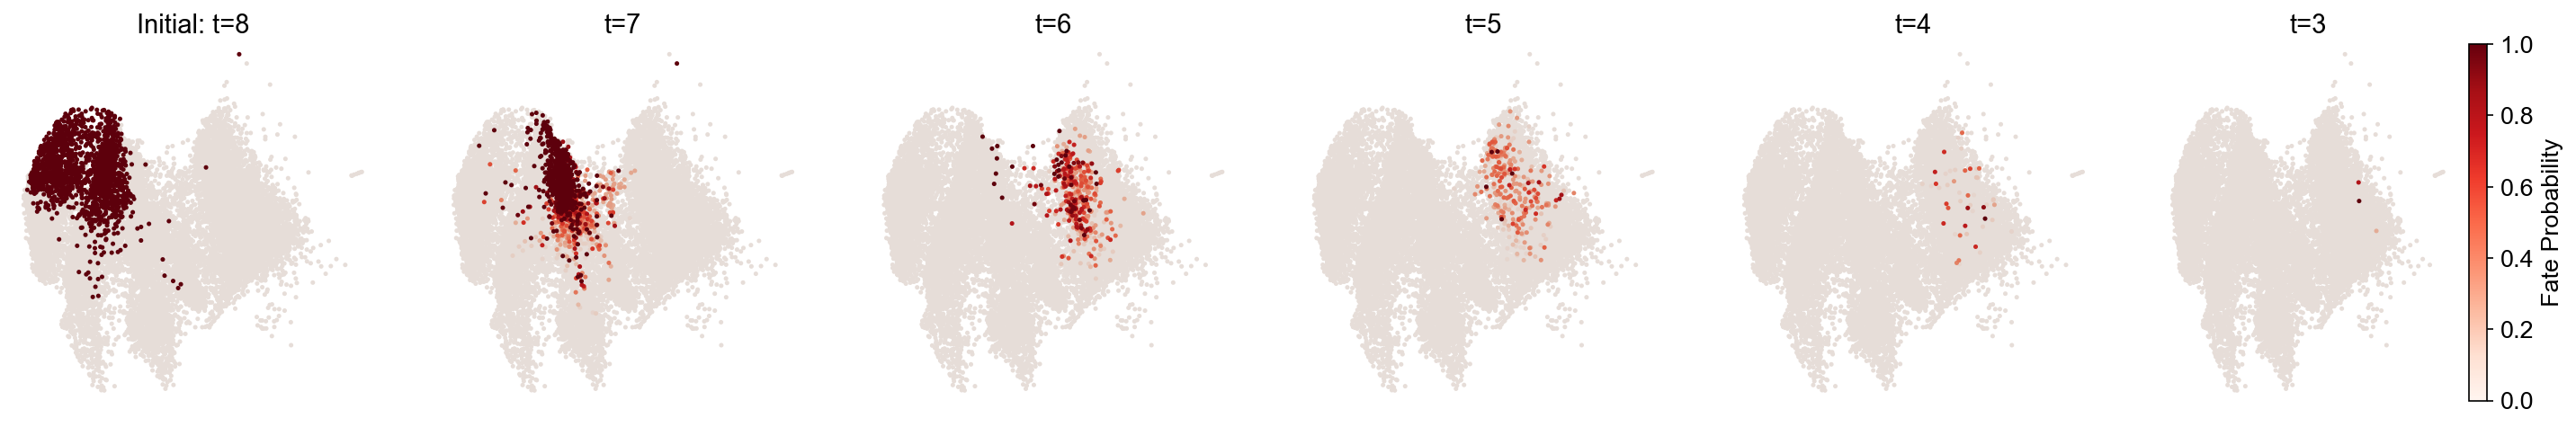

In [20]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True)

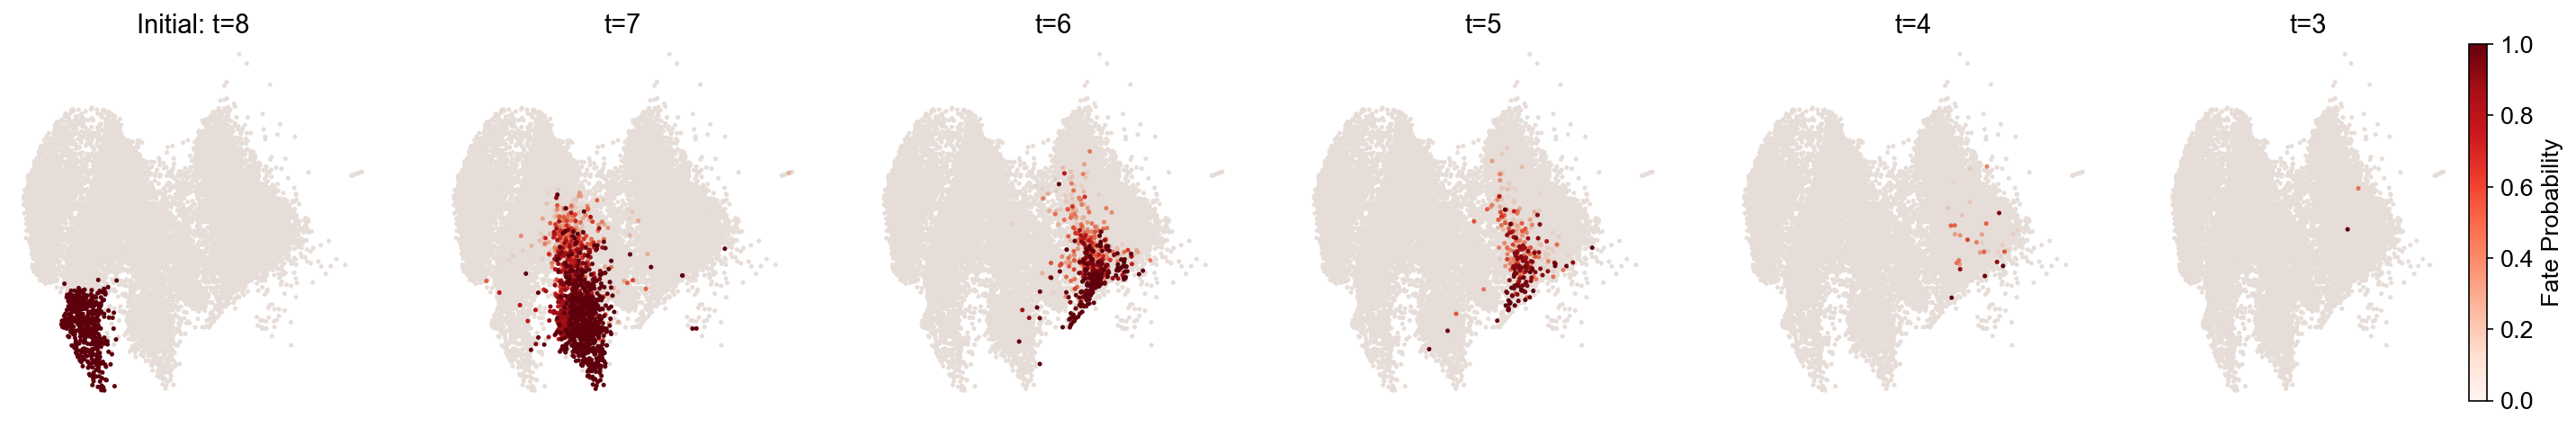

In [21]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True)

#### Gene trend along the trajectory

The results are based on pre-computed dynamic trajectories from the preceding step. It is
better to use the `intraclone_transition_map`. First, show the expression dynamics along the failed trajectory:

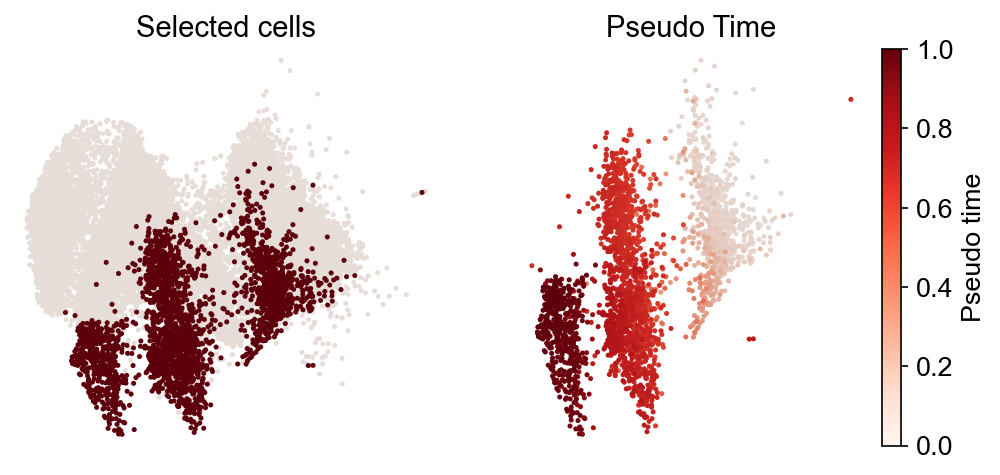

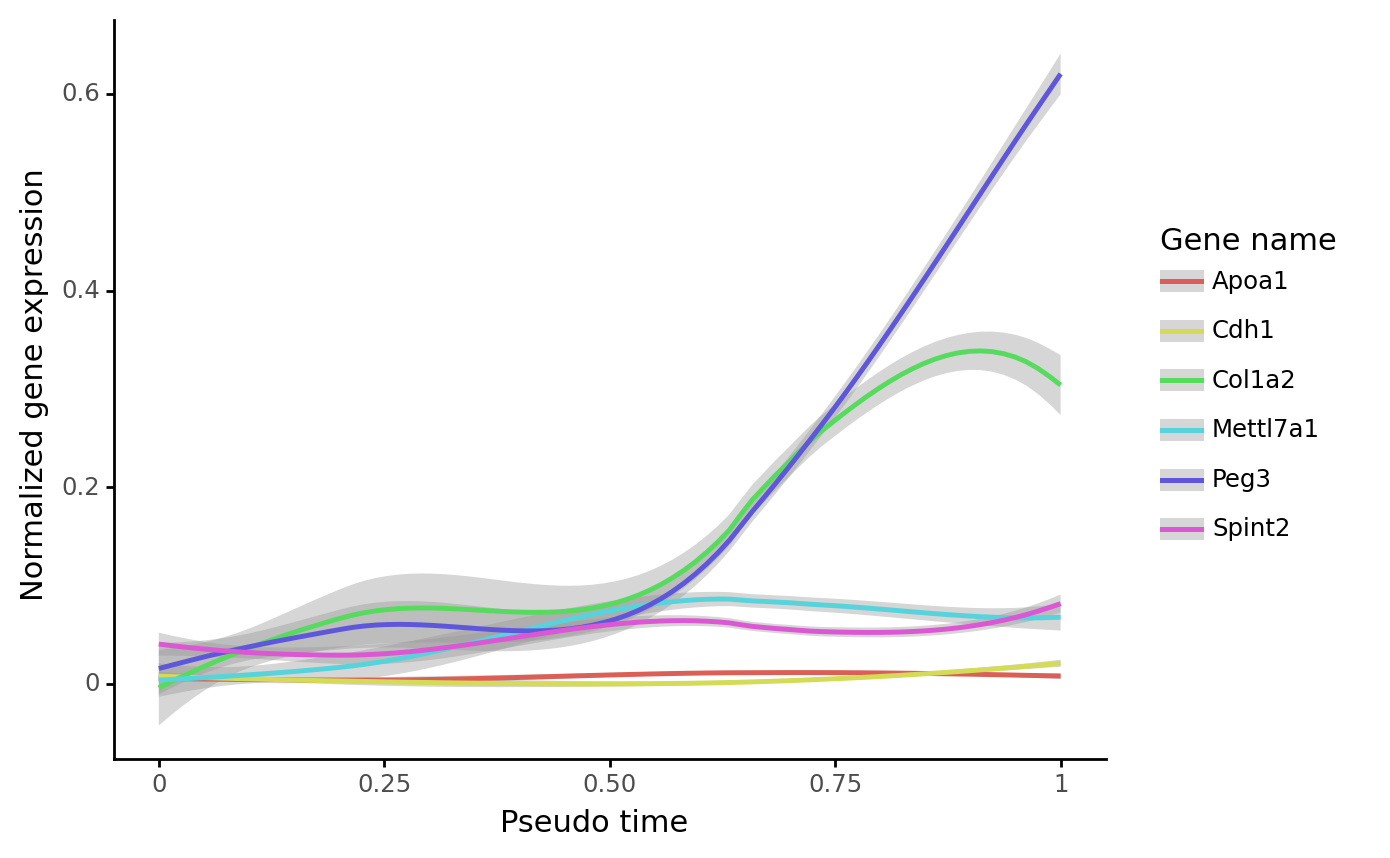

In [22]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Failed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True)

Then, the reprogramming trajectory

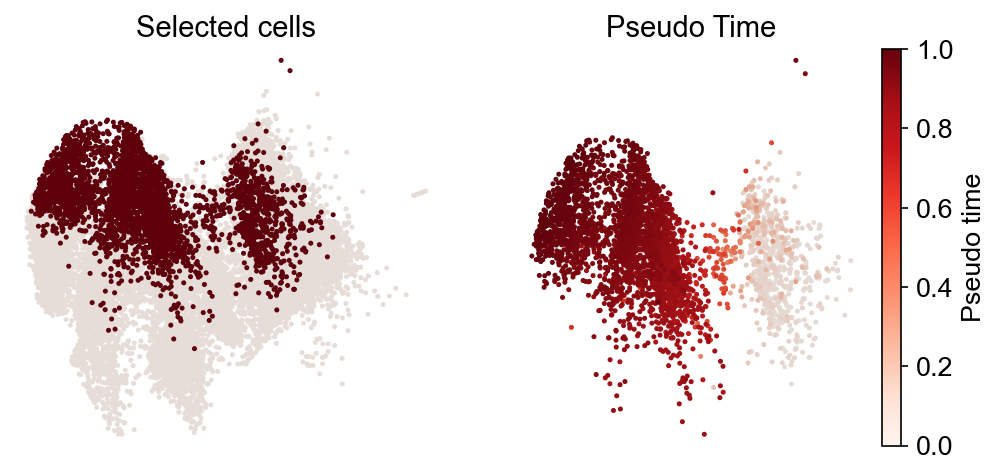

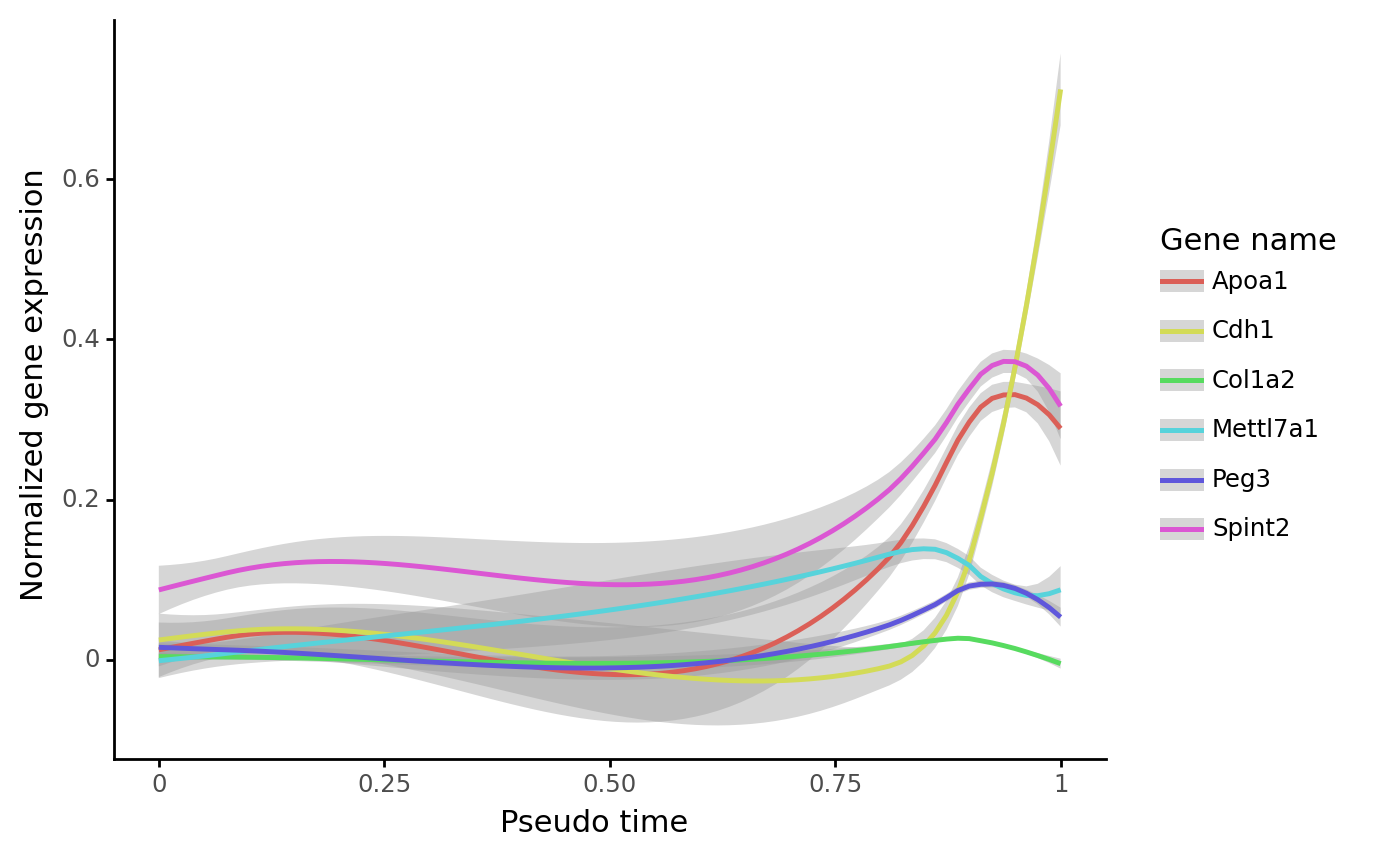

In [23]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True)


### Transition map from only clonal information

Current time ordering from simple sorting: ['3' '4' '5' '6' '7' '8']
--> Clonal cell fraction (day 3-4): 1.0
--> Clonal cell fraction (day 4-5): 0.9844760672703752
--> Clonal cell fraction (day 5-6): 0.9300648882480173
--> Clonal cell fraction (day 6-7): 0.8835638468961081
--> Clonal cell fraction (day 7-8): 0.8965076660988075
--> Clonal cell fraction (day 4-3): 0.1423027166882277
--> Clonal cell fraction (day 5-4): 0.772170151405912
--> Clonal cell fraction (day 6-5): 0.9630106143454487
--> Clonal cell fraction (day 7-6): 0.9346252129471891
--> Clonal cell fraction (day 8-7): 1.0
--> Numer of cells that are clonally related -- day 3: 49  and day 4: 110
--> Numer of cells that are clonally related -- day 4: 761  and day 5: 2142
--> Numer of cells that are clonally related -- day 5: 2580  and day 6: 2994
--> Numer of cells that are clonally related -- day 6: 2747  and day 7: 4389
--> Numer of cells that are clonally related -- day 7: 4210  and day 8: 6094
Valid clone number 'FOR' post s

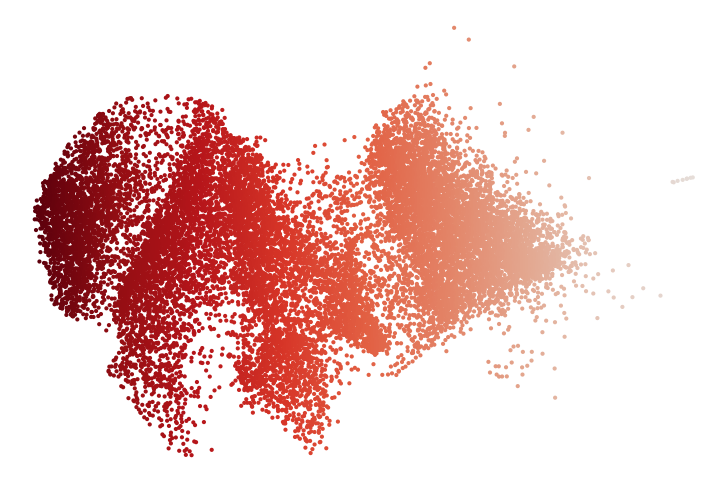

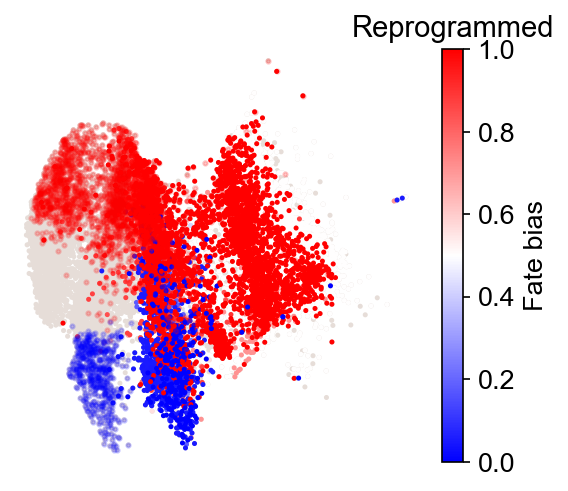

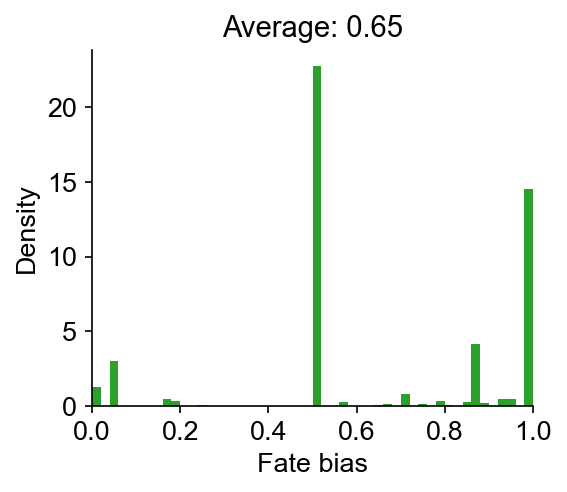

In [24]:
cs.tmap.infer_Tmap_from_clonal_info_alone(adata,method='naive')

cs.pl.binary_fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='clonal_transition_map',
            selected_time_points=[],plot_target_state=True,map_backwards=True,sum_fate_prob_thresh=0)

## Part II: Infer transition map using clones from the last time point

It takes 12 mins to compute for the first time (excluding the time for computing similarity matrix); and 5 mins later. 

In [25]:
initial_time_points=['3','4','5','6','7']
clonal_time_point='8'
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points,clonal_time_point,
        initialize_method='OT',OT_cost='SPD',smooth_array=[15,10,5],noise_threshold=0.2,use_full_Smatrix=True)

-------------------------------New Start--------------------------------------------------
Current time point: 3
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Compute new shortest path distance matrix
--> Chosen mode is distances
Finishing computing shortest-path distance, used time 30.506983041763306
Compute new custon OT matrix
OT solver: duality_gap
Finishing computing optial transport map, used time 1.4705159664154053
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (6654, 770)
--> After excluding zero-sized clones at t2: (6654, 694)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal st

--> Time elapsed:  0.3280489444732666
Compute similarity matrix: load existing data
--> Time elapsed:  0.06151700019836426
--> Time elapsed:  0.24905920028686523
--> Time elapsed:  0.05376791954040527
--> Time elapsed:  0.23285388946533203
Current iteration: 0
Use smooth_round=15
Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Start to smooth the refined clonal map
Phase I: time elapsed --  8.678483247756958
Phase II: time elapsed --  9.074181079864502
Current iteration: 1
Use smooth_round=10
Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Start to smooth the refined clonal map
Phase I: time elapsed --  1.933769941329956
Phase II: time elapsed --  2.37568998336792
Current iteration: 2
Use smooth_round=5
Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Start to smooth the refined clonal map
Phase I: time elapsed --  1.2510979175567627
Phase II: time elapsed --  1.6888329982757568
Final round of Smooth (to expan

In [26]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'OT_transition_map']
Available clusters: ['18', '19', '5', '21', '20', '13', '11', 'Reprogrammed', '22', '2', '8', '16', '3', '7', '9', '15', '0', '10', 'Failed', '12', '4']
Available time points: ['8', '5', '7', '3', '6', '4']
Clonal time points: ['8', '5', '7', '3', '6', '4']


### Fate map

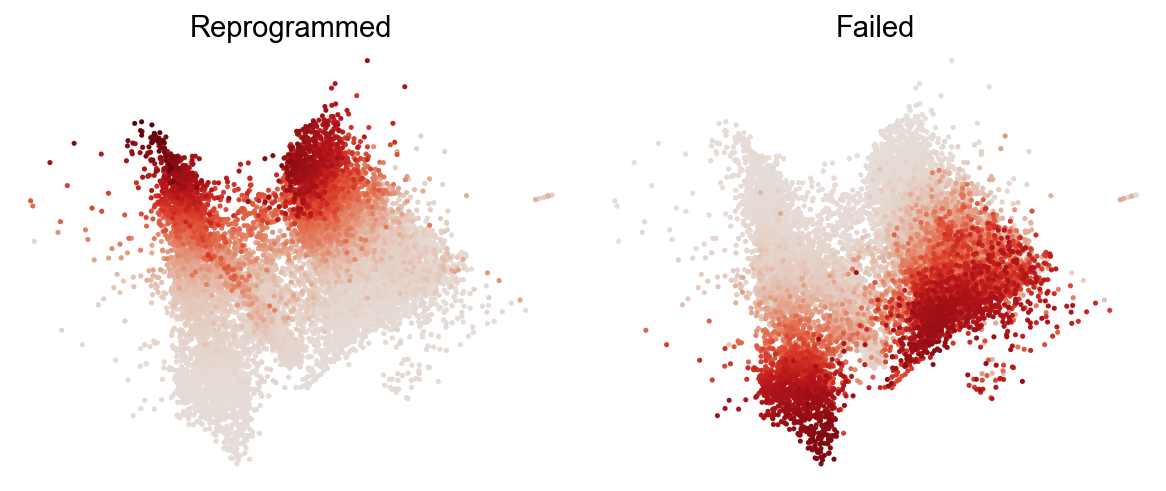

In [27]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='transition_map',map_backwards=True,plot_target_state=False,
               color_bar=False,background=False,auto_color_scale=False,horizontal=True)

### Relative fate bias

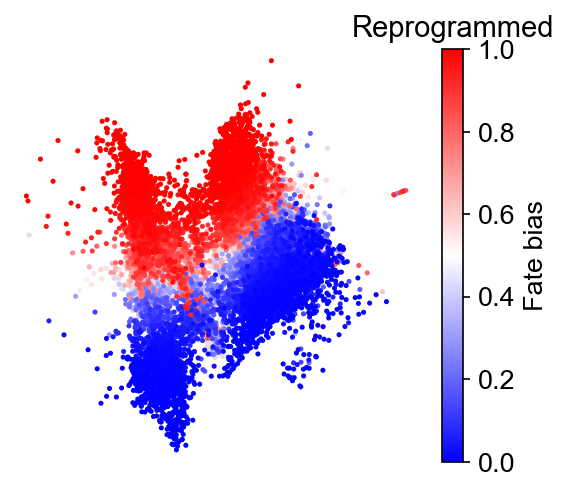

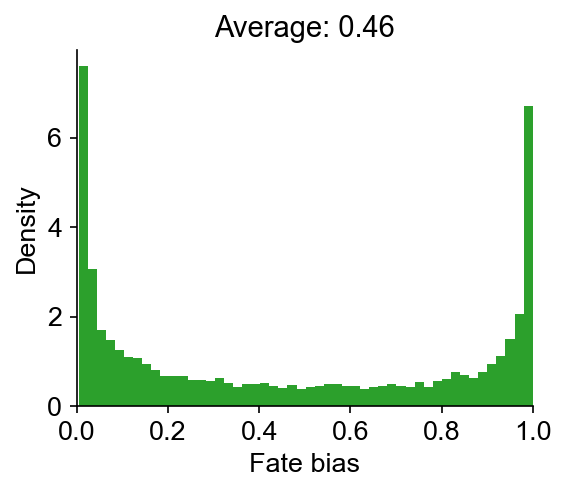

In [28]:
cs.pl.binary_fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

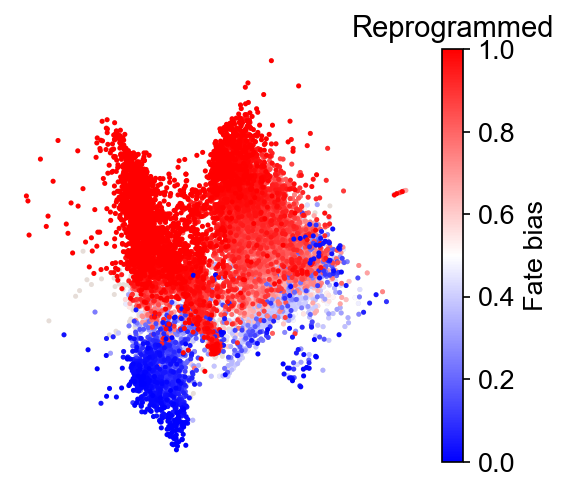

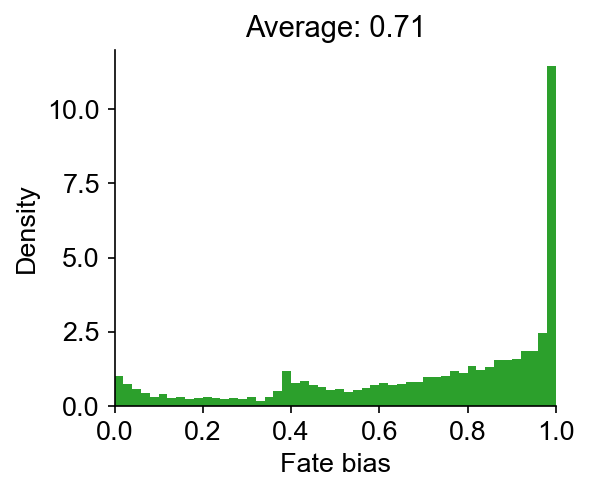

In [29]:
cs.pl.binary_fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='OT_transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

### Dynamic trajectory inference

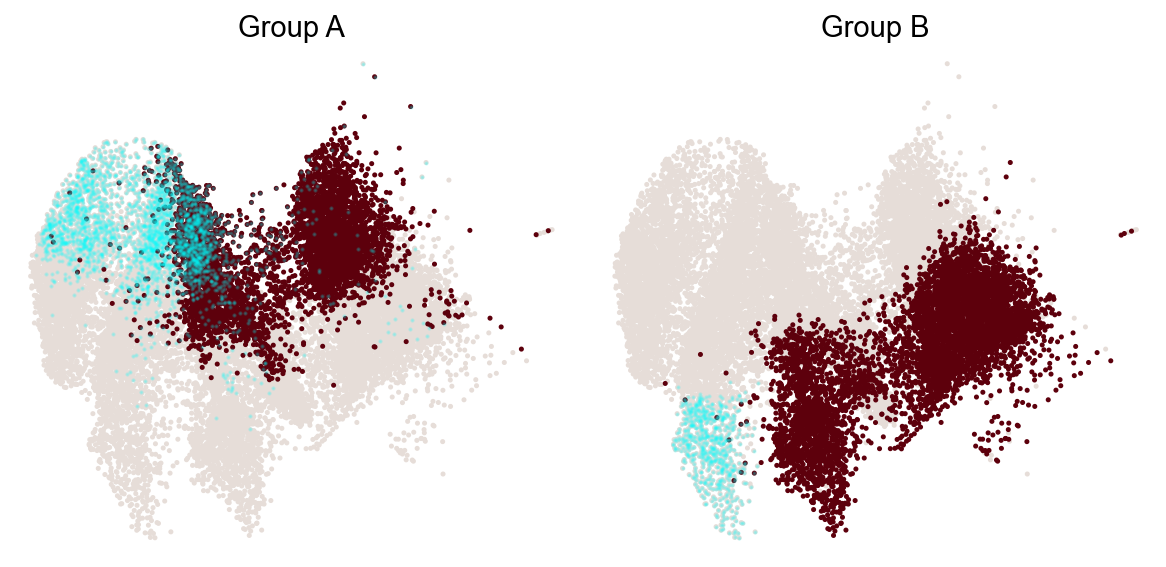

In [30]:
cs.pl.dynamic_trajectory_from_binary_fate_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


### Gene trend along the dynamic trajectory

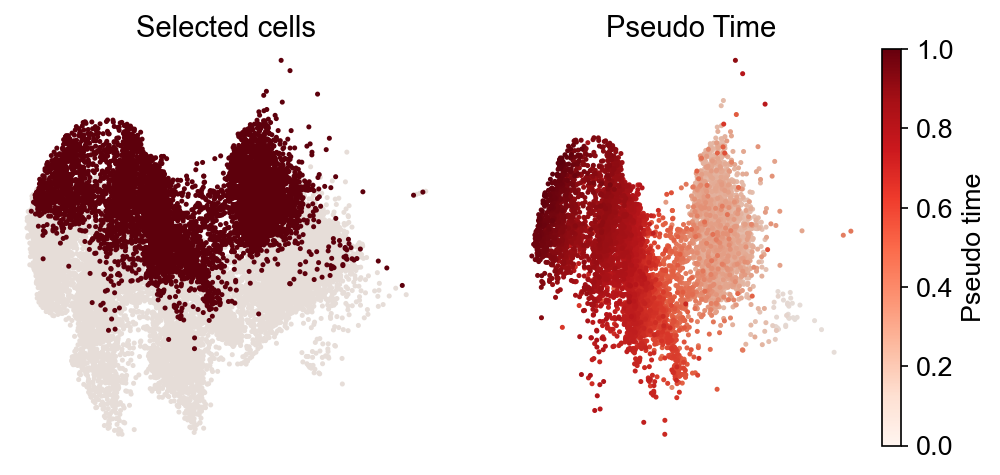

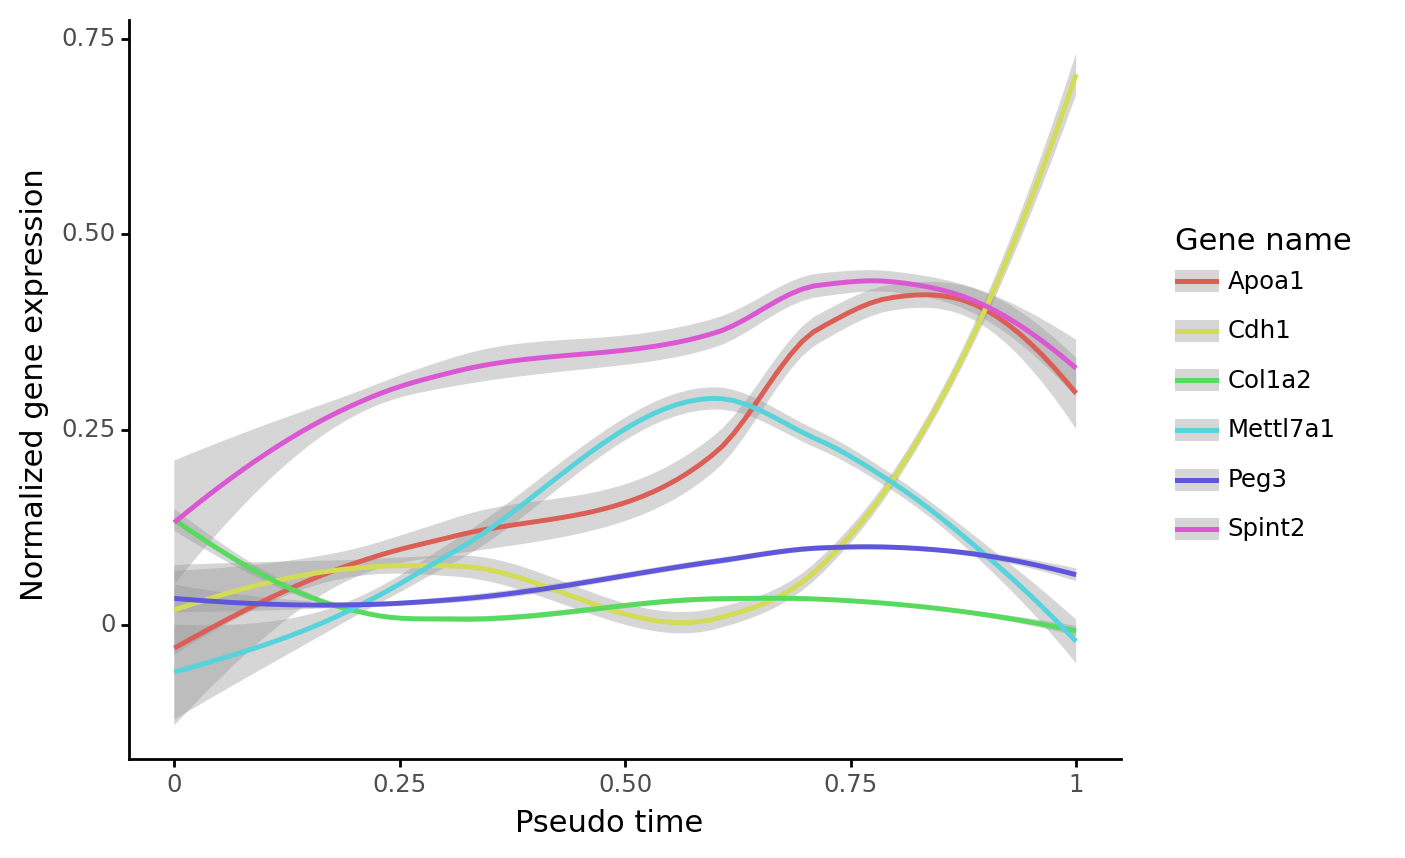

In [31]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=True)
